# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
import pandas as pd
import numpy as np
import json
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score,f1_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.dummy import DummyClassifier
plt.style.use('seaborn')
%matplotlib inline


### Read data from files

In [2]:
# read in the json files
portfolios_data = pd.read_json('portfolio.json', orient='records', lines=True)
profiles_data = pd.read_json('profile.json', orient='records', lines=True)
transcripts_data = pd.read_json('transcript.json', orient='records', lines=True)

#### Look if any of datasets have a null values

In [3]:
# look if dataset has an empty values
portfolios_data.isnull().any()

reward        False
channels      False
difficulty    False
duration      False
offer_type    False
id            False
dtype: bool

In [4]:
profiles_data.isnull().any()

gender               True
age                 False
id                  False
became_member_on    False
income               True
dtype: bool

In [5]:
transcripts_data.isnull().any()

person    False
event     False
value     False
time      False
dtype: bool

# **1. Data Cleaning**

## **Cleaning the portfolio data.**
* Rename id col name to offer_id.
* Apply one-hot encode.
* Apply One-hot encode in offer_type Column

In [6]:
portfolios_data.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [7]:
# one-hot encode offer type
portfolios_data = pd.concat((portfolios_data, pd.get_dummies(portfolios_data['offer_type'])), axis=1)
portfolios_data.drop(['offer_type'], inplace=True, axis=1)

In [8]:
# rename id column
portfolios_data.rename(columns={'id': 'offer_id'}, inplace=True)

In [9]:
df_channels = pd.DataFrame(portfolios_data['channels'].apply(lambda x: ' '.join(x)).str.split(' ', expand=True))
channels = np.unique(df_channels.dropna().values)

In [10]:
# one-hot encode channels
df_channels.columns = channels
for col in channels:
    df_channels[col] = df_channels[col].apply(lambda x: 1 if x else 0)
portfolios_data = pd.concat((portfolios_data, df_channels), axis=1)
portfolios_data.drop(['channels'], inplace=True, axis=1)
portfolios_data.head()

,reward,difficulty,duration,offer_id,bogo,discount,informational,email,mobile,social,web
0,10,10,7,ae264e3637204a6fb9bb56bc8210ddfd,1,0,0,1,1,1,0
1,10,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,1,0,0,1,1,1,1
2,0,0,4,3f207df678b143eea3cee63160fa8bed,0,0,1,1,1,1,0
3,5,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,0,0,1,1,1,0
4,5,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,1,0,1,1,0,0


## **B. Clean Profile data**


* profile: rename id col name to customer_id.
* profile: change age value of 118 to nan.
* profile: create readable date format in became_member_on column.
* profile: dropping rows that has no gender, income, age data
* profile: convert gender values to numeric (0s , 1s)
* profile: add starting years and months columns.

In [11]:
profiles_data.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [12]:
# convert time to datetime
def apply_datetime(x):
    return datetime.strptime(str(x), '%Y%m%d')
profiles_data['became_member_on'] = profiles_data['became_member_on'].apply(lambda x: apply_datetime(x))


In [13]:
profiles_data['age'] = profiles_data['age'].apply(lambda x: None if x == 118 else x)
profiles_data.describe()

,age,income
count,14825.000000,14825.000000
mean,54.393524,65404.991568
std,17.383705,21598.299410
min,18.000000,30000.000000
25%,42.000000,49000.000000
50%,55.000000,64000.000000
75%,66.000000,80000.000000
max,101.000000,120000.000000


In [14]:
profiles_data.dropna(axis=0, inplace=True)

In [15]:
profiles_data['gender'] = profiles_data['gender'].apply(lambda x: 0 if x == 'F' else 1)
profiles_data.dropna(inplace=True)

In [16]:
profiles_data.rename(columns={'id': 'customer_id'}, inplace=True)
profiles_data.reset_index(drop=True, inplace=True)
profiles_data.head()

,gender,age,customer_id,became_member_on,income
0,0,55.0,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0
1,0,75.0,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0
2,1,68.0,e2127556f4f64592b11af22de27a7932,2018-04-26,70000.0
3,1,65.0,389bc3fa690240e798340f5a15918d5c,2018-02-09,53000.0
4,1,58.0,2eeac8d8feae4a8cad5a6af0499a211d,2017-11-11,51000.0


In [17]:
profiles_data.isnull().any()

gender              False
age                 False
customer_id         False
became_member_on    False
income              False
dtype: bool

In [18]:
profiles_data['year'] = profiles_data['became_member_on'].dt.year
profiles_data['month'] = profiles_data['became_member_on'].dt.month

In [19]:
profiles_data.head()

,gender,age,customer_id,became_member_on,income,year,month
0,0,55.0,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,2017,7
1,0,75.0,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,2017,5
2,1,68.0,e2127556f4f64592b11af22de27a7932,2018-04-26,70000.0,2018,4
3,1,65.0,389bc3fa690240e798340f5a15918d5c,2018-02-09,53000.0,2018,2
4,1,58.0,2eeac8d8feae4a8cad5a6af0499a211d,2017-11-11,51000.0,2017,11


## **C. Clean Transcript Data**

* transcript: rename person col name to customer_id.
* transcript: creating separate columns for amount and offer_id from value col.
* transcript: dropping transaction rows whose customer_id is not in profile:customer_id
* transcript: converting time in hours to time in days
* segregate offer and transaction data
* transcript: finally drop duplicates.

In [20]:
transcripts_data.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [21]:
transcripts_data.rename(columns={'person': 'customer_id'}, inplace=True)

In [22]:
# add two new columns - id for offer and amount spent by user - based on value column
transcripts_data['offer_id'] = None
transcripts_data['amount'] = None

for i in range(len(transcripts_data)):
    key, value = list(transcripts_data.iloc[i]['value'].items())[0]
    if key in['offer_id', 'offer id']:
        transcripts_data.at[i, 'offer_id'] = value
    elif key == 'amount':
        transcripts_data.at[i, 'amount'] = float(value)



In [23]:
transcripts_data.drop(['value'], inplace=True, axis=1)

In [24]:
# delete duplicates and set time in days
transcripts_data['time'] = transcripts_data['time'].apply(lambda x: x / 24)
transcripts_data.drop_duplicates(inplace=True)
transcripts_data.reset_index(drop=True, inplace=True)

In [25]:
transcripts_data.head()

,customer_id,event,time,offer_id,amount
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,None
1,a03223e636434f42ac4c3df47e8bac43,offer received,0.0,0b1e1539f2cc45b7b9fa7c272da2e1d7,None
2,e2127556f4f64592b11af22de27a7932,offer received,0.0,2906b810c7d4411798c6938adc9daaa5,None
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0.0,fafdcd668e3743c1bb461111dcafc2a4,None
4,68617ca6246f4fbc85e91a2a49552598,offer received,0.0,4d5c57ea9a6940dd891ad53e9dbe8da0,None


In [26]:
# filte transcript data by users' ids, which are present in profiles dataset
transcripts_data = transcripts_data[transcripts_data['customer_id'].isin(profiles_data['customer_id'])]
# look at unique events
events = np.unique(transcripts_data['event'].values)
events

array(['offer completed', 'offer received', 'offer viewed', 'transaction'],
      dtype=object)

In [27]:
# create dataset with only offers in it
offers_data = transcripts_data[transcripts_data['event'] != 'transaction']
# one-hot encode offer event
offers_data ['received'] = offers_data.event.apply(lambda x: 1 if x == 'offer received' else 0)
offers_data ['completed'] = offers_data.event.apply(lambda x: 1 if x == 'offer completed' else 0)
offers_data ['viewed'] = offers_data.event.apply(lambda x: 1 if x == 'offer viewed' else 0)

offers_data.drop(columns=['event', 'amount'], inplace=True, axis=1)
offers_data[['viewed', 'completed', 'received']].apply(pd.Series.value_counts)

,viewed,completed,received
0,98571,116361,81930
1,49860,32070,66501


# Exploratory Data Analysis

## 1. Profile data

In [28]:
profiles_data.head()

,gender,age,customer_id,became_member_on,income,year,month
0,0,55.0,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,2017,7
1,0,75.0,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,2017,5
2,1,68.0,e2127556f4f64592b11af22de27a7932,2018-04-26,70000.0,2018,4
3,1,65.0,389bc3fa690240e798340f5a15918d5c,2018-02-09,53000.0,2018,2
4,1,58.0,2eeac8d8feae4a8cad5a6af0499a211d,2017-11-11,51000.0,2017,11


In [29]:
# Checking the null vlaues
profiles_data.isnull().any()

gender              False
age                 False
customer_id         False
became_member_on    False
income              False
year                False
month               False
dtype: bool

In [30]:
# Compute gender distribution in customer's data
profiles_data.gender.value_counts()

1    8696
0    6129
Name: gender, dtype: int64

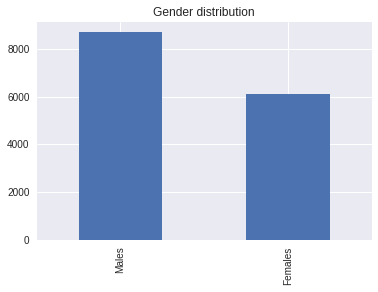

In [31]:
ax = profiles_data.gender.value_counts().plot(kind='bar', title='Gender distribution')
ax.set_xticklabels(['Males', 'Females']);

Among the customers prevail men

In [32]:
# Stats of customer age and income attributes when income is specified
profiles_data[profiles_data['income'] != None].describe()

,gender,age,income,year,month
count,14825.000000,14825.000000,14825.000000,14825.000000,14825.000000
mean,0.586577,54.393524,65404.991568,2016.620169,6.695582
std,0.492464,17.383705,21598.299410,1.198245,3.488853
min,0.000000,18.000000,30000.000000,2013.000000,1.000000
25%,0.000000,42.000000,49000.000000,2016.000000,4.000000
50%,1.000000,55.000000,64000.000000,2017.000000,7.000000
75%,1.000000,66.000000,80000.000000,2017.000000,10.000000
max,1.000000,101.000000,120000.000000,2018.000000,12.000000


In [33]:
#Compute what percent of customers vs which year enrolled as a member
membership_each_year = profiles_data.groupby('year')['year'].count()

membership_each_year = (membership_each_year / membership_each_year.sum()) * 100
membership_each_year

year
2013     1.848229
2014     4.465430
2015    10.772344
2016    20.397976
2017    37.767285
2018    24.748735
Name: year, dtype: float64

In [34]:
# Compute what percent of customers vs which month enrolled as a member
membership_each_month = profiles_data['became_member_on'].dt.month.value_counts()

membership_each_month = (membership_each_month /  membership_each_year.sum()) * 100
membership_each_month.sort_index()

1     1327.0
2     1042.0
3     1145.0
4     1145.0
5     1152.0
6     1105.0
7     1189.0
8     1395.0
9     1299.0
10    1386.0
11    1268.0
12    1372.0
Name: became_member_on, dtype: float64

## Profile General Distribution — Age, Income, Members

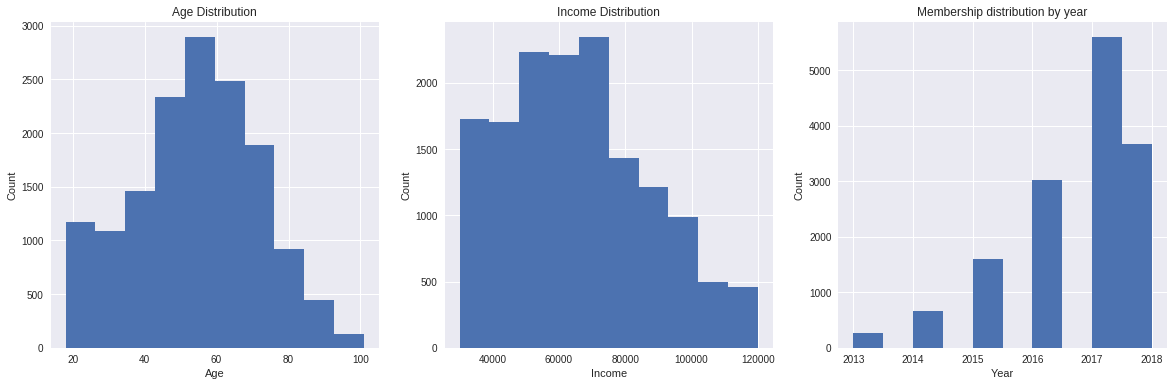

In [35]:
# to be able to draw three subplots in a row
fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(20, 6))
# plot a age distribution in data
profiles_data['age'].plot(kind='hist', ax=ax[0])
ax[0].set_xlabel('Age')
ax[0].set_ylabel('Count')
ax[0].set_title('Age Distribution')

# plot a income distribution in data
profiles_data['income'].plot(kind='hist', ax=ax[1])
ax[1].set_xlabel('Income')
ax[1].set_ylabel('Count')
ax[1].set_title('Income Distribution')

# plot a start_year distribution
profiles_data['year'].plot(kind='hist', ax=ax[2])
ax[2].set_xlabel('Year')
ax[2].set_ylabel('Count')
ax[2].set_title('Membership distribution by year');

On the age distribution plot we see, that median age of customers is 60 and most of them belong to age between 40 to 70. 

Income distribution shows that the number of customers whose average salary is less than 70K is high

The third plot shows that number of customers was growing year by year, and only on last, 2018 is a gap, when number of customers is lower than in 2017, but higher than in 2016.

### Income distribution as a function a gender

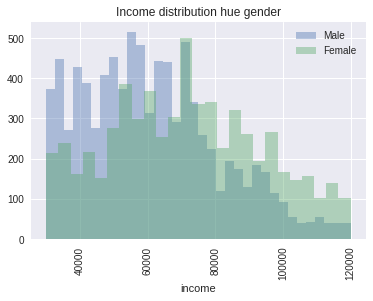

In [36]:
sns.distplot(profiles_data[profiles_data['gender'] == 1]['income'], kde=False, label='Male')
sns.distplot(profiles_data[profiles_data['gender'] == 0]['income'], kde=False, label='Female')
plt.xticks(rotation=90)
plt.title('Income distribution hue gender')
plt.legend();

In this plot we can see, that the minimum and maximum income for both male and female are almost the same, but the count of male customers in low-income level is higher than that of female customers.

### Age distribution as a function of gender

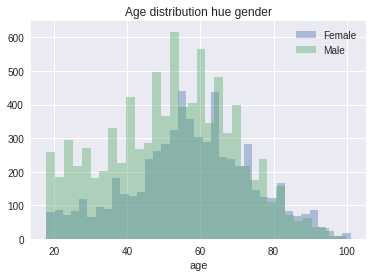

In [37]:
sns.distplot(profiles_data[profiles_data['gender'] == 0]['age'], kde=False, label='Female')
sns.distplot(profiles_data[profiles_data['gender'] == 1]['age'], kde=False, label='Male')
plt.title('Age distribution hue gender')
plt.legend();

Number of males and females are distributed equaly - maximum and minimum age for both genders is the same, but we have more younger men.

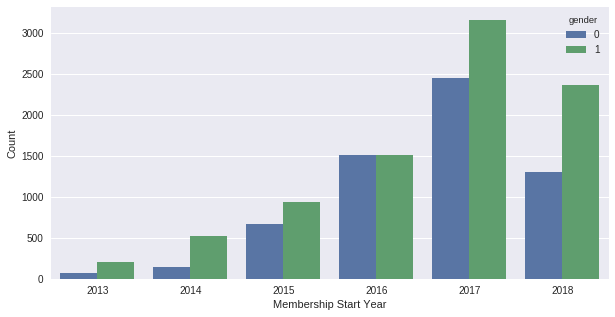

In [38]:
# groupby start_year and gender to plot a graph
g = profiles_data.groupby(['year', 'gender'], as_index=False).size()
g = g.reset_index()
g.columns = ['year', 'gender', 'count']
# plot a bar graph for age distribution as a function of gender in membership program
plt.figure(figsize=(10, 5))
sns.barplot(x='year', y='count', hue='gender', data=g)
plt.xlabel('Membership Start Year')
plt.ylabel('Count');

We see, that the Starbucks rewards program is more interesting for men rather for women.

# 2.Transaction data

### Compute the event type distribution

In [39]:
events = transcripts_data['event'].value_counts()
events

transaction        123957
offer received      66501
offer viewed        49860
offer completed     32070
Name: event, dtype: int64

In [40]:
transactions = events.sum()

transactions_in_percent = 100 * events[0] / transactions
offers_in_percent = 100 * events[1:].sum() / transactions

transactions_in_percent, offers_in_percent

(45.507511344112075, 54.492488655887925)

### Combine offer, customer and transactions data

In [41]:
# get all users' ids
users_ids = offers_data['customer_id'].unique()

In [43]:
# merge all datasets in one
data = []
# for every unique id of users
for id in users_ids:
    # get profile of user
    user = profiles_data[profiles_data['customer_id'] == id]
    # get actions of user
    actions = transcripts_data[transcripts_data['customer_id'] == id]
    # get payments
    payments = actions[actions['event'] == 'transaction']
    # get offers with diven id oedered to customer
    offers = offers_data[offers_data['customer_id'] == id]
    # get offers which were received, viewed and completed 
    offer_received_data = offers[offers['received'] == 1]
    offer_completed_data = offers[offers['completed'] == 1]
    offer_viewed_data = offers[offers['viewed'] == 1]
    rows = []
    # for each offer received
    for ind in range(offer_received_data.shape[0]):
        # get id
        offer_id = offer_received_data.iloc[ind]['offer_id']
        # get portfolio
        portfolio = portfolios_data[portfolios_data['offer_id'] == offer_id]
        # get offers with current id
        offer = offers[offers['offer_id'] == offer_id]
        # calculate start and end time
        start_offer = offer_received_data.iloc[ind]['time']
        end_offer = start_offer + portfolio['duration'].values[0]
        # was offer completed    
        filter_completed = (
            offer_completed_data['time'] >= start_offer) & (offer_completed_data['time'] <= end_offer)
        # was osser viewed in time (before offer ended)
        filter_viewed = (
                offer_viewed_data['time'] >= start_offer) & (offer_viewed_data['time'] <= end_offer)
        # was offer successful (viewed and completed within end time)
        offer_successful = filter_completed.sum() > 0 and filter_viewed.sum() > 0
        # get transaction amount in time of the offer
        transactions_filter = (payments['time'] >= start_offer) & (payments['time'] <= end_offer)
        transaction_in_time = payments[transactions_filter]
        # get total transaction
        transaction_total = transaction_in_time['amount'].sum()
        dict_row = {
                'id_offer': offer_id,
                'id_user': id,
                'time_start': start_offer,
                'time_end': end_offer,
                'total_spent': transaction_total,
                'is_successful': int(offer_successful),
            }
        dict_row.update(user.iloc[0].to_dict())
        dict_row.update(portfolio.iloc[0].to_dict())
        rows.append(dict_row)
    data.extend(rows)
df = pd.DataFrame(data)
df  

,id_offer,id_user,time_start,time_end,total_spent,is_successful,gender,age,customer_id,became_member_on,...,difficulty,duration,offer_id,bogo,discount,informational,email,mobile,social,web
0,9b98b8c7a33c4b65b9aebfe6a799e6d9,78afa995795e4d85b5d9ceeca43f5fef,0.0,7.0,37.67,1,0,75.0,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,...,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,0,0,1,1,1,0
1,5a8bc65990b245e5a138643cd4eb9837,78afa995795e4d85b5d9ceeca43f5fef,7.0,10.0,49.39,0,0,75.0,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,...,0,3,5a8bc65990b245e5a138643cd4eb9837,0,0,1,1,1,1,0
2,ae264e3637204a6fb9bb56bc8210ddfd,78afa995795e4d85b5d9ceeca43f5fef,17.0,24.0,48.28,1,0,75.0,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,...,10,7,ae264e3637204a6fb9bb56bc8210ddfd,1,0,0,1,1,1,0
3,f19421c1d4aa40978ebb69ca19b0e20d,78afa995795e4d85b5d9ceeca43f5fef,21.0,26.0,48.28,1,0,75.0,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,...,5,5,f19421c1d4aa40978ebb69ca19b0e20d,1,0,0,1,1,1,1
4,2906b810c7d4411798c6938adc9daaa5,e2127556f4f64592b11af22de27a7932,0.0,7.0,0.00,0,1,68.0,e2127556f4f64592b11af22de27a7932,2018-04-26,...,10,7,2906b810c7d4411798c6938adc9daaa5,0,1,0,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66496,2906b810c7d4411798c6938adc9daaa5,3cc622f76e464bc1809a71e871579d6c,24.0,31.0,34.04,0,1,59.0,3cc622f76e464bc1809a71e871579d6c,2017-08-20,...,10,7,2906b810c7d4411798c6938adc9daaa5,0,1,0,1,1,1,0
66497,5a8bc65990b245e5a138643cd4eb9837,01fe5ec668f241608eb2f7ec374cb1b7,24.0,27.0,19.92,0,1,44.0,01fe5ec668f241608eb2f7ec374cb1b7,2017-08-02,...,0,3,5a8bc65990b245e5a138643cd4eb9837,0,0,1,1,1,1,0
66498,9b98b8c7a33c4b65b9aebfe6a799e6d9,d825b707198046e39baa4fdcfa11d621,24.0,31.0,28.42,0,1,61.0,d825b707198046e39baa4fdcfa11d621,2018-04-23,...,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,0,0,1,1,1,0
66499,2298d6c36e964ae4a3e7e9706d1fb8c2,c207a8a8ef5c47ee970ca45f859e07eb,24.0,31.0,75.84,1,0,52.0,c207a8a8ef5c47ee970ca45f859e07eb,2017-12-23,...,7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,0,1,0,1,1,1,1


In [44]:
df['is_successful'].value_counts()

0    35136
1    31365
Name: is_successful, dtype: int64

In [45]:
df.columns

Index(['id_offer', 'id_user', 'time_start', 'time_end', 'total_spent',
       'is_successful', 'gender', 'age', 'customer_id', 'became_member_on',
       'income', 'year', 'month', 'reward', 'difficulty', 'duration',
       'offer_id', 'bogo', 'discount', 'informational', 'email', 'mobile',
       'social', 'web'],
      dtype='object')

In [46]:
df[['time_start', 'time_end', 'total_spent',
       'is_successful', 'gender', 'age', 'customer_id', 'became_member_on',
       'income', 'year', 'month', 'reward', 'difficulty', 'duration',
       'offer_id', 'bogo', 'discount', 'informational', 'email', 'mobile',
       'social', 'web']].to_csv('offer_analysis.csv', index=False)

In [47]:
df = pd.read_csv('offer_analysis.csv', parse_dates=['became_member_on'])

In [48]:
df.head()

,time_start,time_end,total_spent,is_successful,gender,age,customer_id,became_member_on,income,year,...,difficulty,duration,offer_id,bogo,discount,informational,email,mobile,social,web
0,0.0,7.0,37.67,1,0,75.0,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,2017,...,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,0,0,1,1,1,0
1,7.0,10.0,49.39,0,0,75.0,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,2017,...,0,3,5a8bc65990b245e5a138643cd4eb9837,0,0,1,1,1,1,0
2,17.0,24.0,48.28,1,0,75.0,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,2017,...,10,7,ae264e3637204a6fb9bb56bc8210ddfd,1,0,0,1,1,1,0
3,21.0,26.0,48.28,1,0,75.0,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,2017,...,5,5,f19421c1d4aa40978ebb69ca19b0e20d,1,0,0,1,1,1,1
4,0.0,7.0,0.00,0,1,68.0,e2127556f4f64592b11af22de27a7932,2018-04-26,70000.0,2018,...,10,7,2906b810c7d4411798c6938adc9daaa5,0,1,0,1,1,1,0


In [49]:
g = df.groupby('offer_id')['is_successful'].agg(['count', 'sum'])
g['percent_success'] = (g['sum'] / g['count']) * 100
g

,count,sum,percent_success
offer_id,,,
0b1e1539f2cc45b7b9fa7c272da2e1d7,6726,3078,45.762712
2298d6c36e964ae4a3e7e9706d1fb8c2,6655,4841,72.742299
2906b810c7d4411798c6938adc9daaa5,6631,3165,47.730357
3f207df678b143eea3cee63160fa8bed,6657,514,7.721196
4d5c57ea9a6940dd891ad53e9dbe8da0,6593,3410,51.721523
5a8bc65990b245e5a138643cd4eb9837,6643,417,6.277284
9b98b8c7a33c4b65b9aebfe6a799e6d9,6685,3228,48.287210
ae264e3637204a6fb9bb56bc8210ddfd,6683,3652,54.646117
f19421c1d4aa40978ebb69ca19b0e20d,6576,4052,61.618005


### Generate a plot that illustrates:
##### How many customers were provided with a specific offer?
##### Offer success rate (percentsuccess)

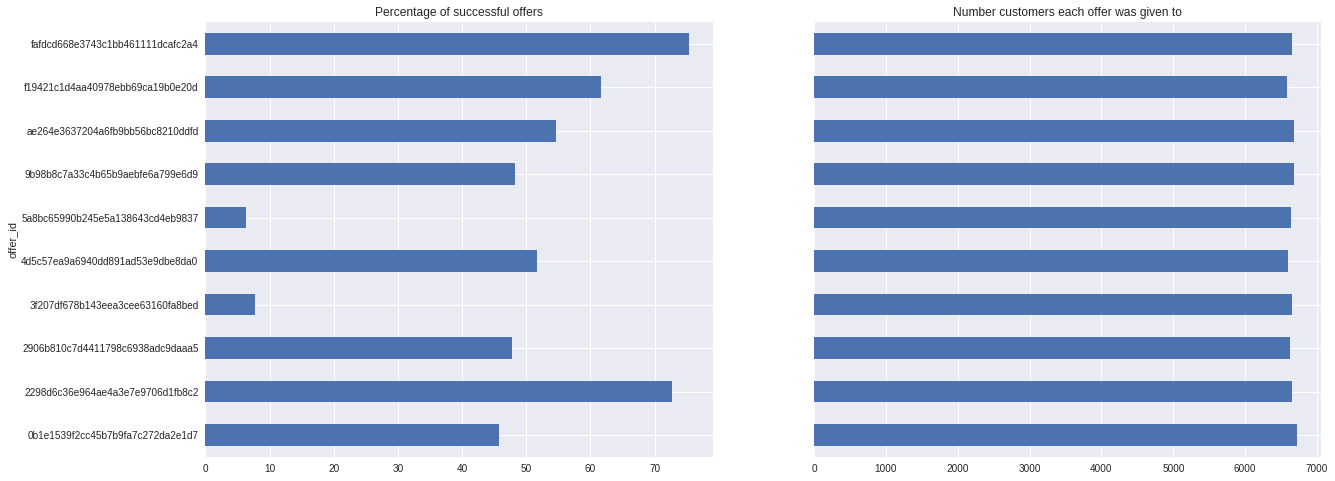

In [50]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(20, 8), sharey=True)
g['percent_success'].plot(kind='barh', ax=ax[0])
ax[0].set_title('Percentage of successful offers')
g['count'].plot(kind='barh', ax=ax[1])
ax[1].set_title('Number customers each offer was given to');

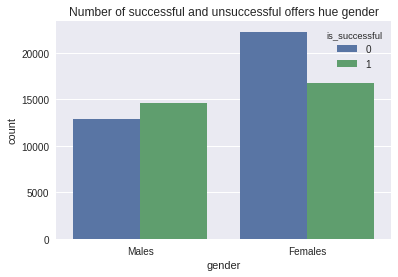

In [51]:
ax = sns.countplot('gender', hue='is_successful', data=df)
ax.set_xticklabels(['Males', 'Females'])
ax.set_title('Number of successful and unsuccessful offers hue gender');

We see, that offers, which were sent to men, are more successful than offers sent to women.  

# Build models

In [52]:
# look at columns
print(df.columns)

Index(['time_start', 'time_end', 'total_spent', 'is_successful', 'gender',
       'age', 'customer_id', 'became_member_on', 'income', 'year', 'month',
       'reward', 'difficulty', 'duration', 'offer_id', 'bogo', 'discount',
       'informational', 'email', 'mobile', 'social', 'web'],
      dtype='object')


In [53]:
columns_for_prediction = ['gender', 'age', 
       'income', 'reward', 'difficulty', 'duration',
       'bogo', 'discount', 'informational', 'email', 'mobile',
       'social', 'web']
binary_columns = ['bogo', 'discount', 'informational', 'email', 'mobile',
       'social', 'web', 'gender']
num_columns = ['age', 'income', 'reward', 'difficulty', 'duration']


In [54]:
# separate features from targets
X = df[columns_for_prediction]
y = df['is_successful']

In [55]:
# create pipline to preprocess features. There are binary and numeric features, so they need to be preprocessed
# in different way. For example, we can leave the binary features without changing, but numeric scale
pipeline = Pipeline(steps = [       
    ('feature_processing', FeatureUnion(
        transformer_list = [        
            ('binary_processing', FunctionTransformer(lambda data: data[binary_columns])), 
               
            ('numeric_processing', Pipeline(steps = [
                ('selecting', FunctionTransformer(lambda data: data[num_columns])),
                ('scaling', StandardScaler())            
                        ])),
        ]))])

In [56]:
X_train, X_test, y_train,  y_test = train_test_split(X, y, test_size=0.2, random_state=17)

In [57]:
X_train = pipeline.fit_transform(X_train)
X_test = pipeline.transform(X_test)

### Construct Adaboost Classifier

In [92]:
# find best Adaboost
parameters = {'n_estimators': [100, 150, 200, 500, 1000]}
gs_adaboost = GridSearchCV(AdaBoostClassifier(), param_grid=parameters, cv=5, scoring='f1',
                          verbose=1, n_jobs=-1)
gs_adaboost.fit(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:  2.6min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=AdaBoostClassifier(algorithm='SAMME.R',
                                          base_estimator=None,
                                          learning_rate=1.0, n_estimators=50,
                                          random_state=None),
             iid='deprecated', n_jobs=-1,
             param_grid={'n_estimators': [100, 150, 200, 500, 1000]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='f1', verbose=1)

In [93]:
gs_adaboost.best_score_, gs_adaboost.best_params_

(0.7028058484132627, {'n_estimators': 150})

In [94]:
# save model
adaboost = gs_adaboost.best_estimator_

### Construct LogisticRegressionClassifier

In [86]:
# find best LogisticRegression
parameters = {'penalty': ['l1', 'l2', 'elasticnet', None], 'C': [0.001, 0.01, 0.1, 1]}
gs_lr = GridSearchCV(LogisticRegression(), param_grid=parameters, cv=5, scoring='f1',
                          verbose=1, n_jobs=-1)
gs_lr.fit(X_train, y_train)
gs_lr.best_score_, gs_lr.best_params_

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    2.9s finished


(0.6893166063943035, {'C': 1, 'penalty': 'l2'})

In [87]:
lr = gs_lr.best_estimator_

### Construct Dummy Classifier

In [88]:
dummy = DummyClassifier()
dummy.fit(X_train, y_train)
f1_score(y_test, dummy.predict(X_test))

0.47714924896132943

### Compare two models

In [95]:
# get prediction for train and test dataset
adaboost_prediction_test = adaboost.predict(X_test)
lr_prediction_test = lr.predict(X_test)
adaboost_prediction_train = adaboost.predict(X_train)
lr_prediction_train = lr.predict(X_train)

#### Plot confusion matrixes

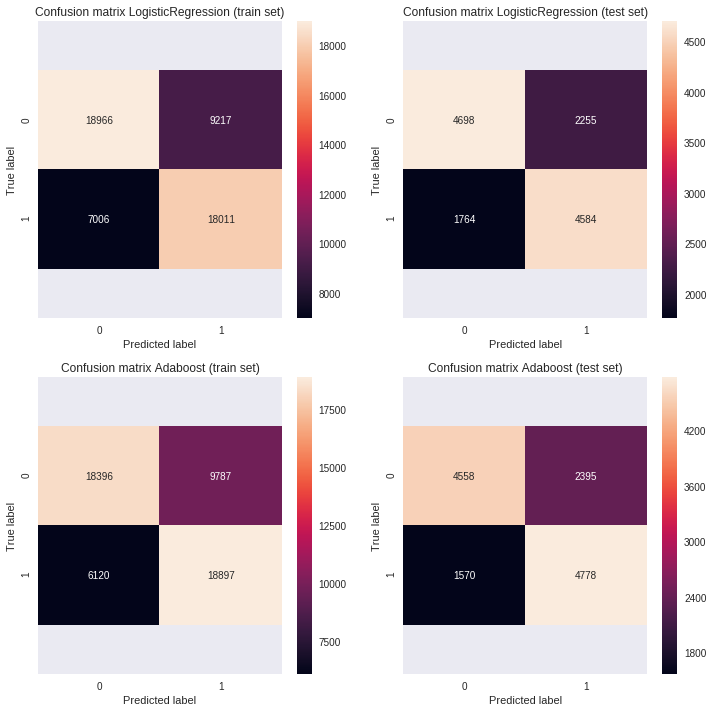

In [96]:
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
sns.heatmap(confusion_matrix(y_train, lr_prediction_train), annot=True, fmt='d', ax=axes[0,0])
bot, top = axes[0,0].get_ylim() 
axes[0, 0].set_ylim(bot + 0.5, top - 0.5)
axes[0, 0].set_xlabel('Predicted label')
axes[0, 0].set_ylabel('True label')
axes[0, 0].set_title('Confusion matrix LogisticRegression (train set)')
sns.heatmap(confusion_matrix(y_test, lr_prediction_test), annot=True, fmt='d', ax=axes[0, 1])
bot, top = axes[0, 1].get_ylim() 
axes[0, 1].set_ylim(bot + 0.5, top - 0.5)
axes[0, 1].set_xlabel('Predicted label')
axes[0, 1].set_ylabel('True label')
axes[0, 1].set_title('Confusion matrix LogisticRegression (test set)')

sns.heatmap(confusion_matrix(y_train, adaboost_prediction_train), annot=True, fmt='d', ax=axes[1, 0])
bot, top = axes[1, 0].get_ylim() 
axes[1, 0].set_ylim(bot + 0.5, top - 0.5)
axes[1, 0].set_xlabel('Predicted label')
axes[1, 0].set_ylabel('True label')
axes[1, 0].set_title('Confusion matrix Adaboost (train set)')

axes[1, 1] = sns.heatmap(confusion_matrix(y_test, adaboost_prediction_test), annot=True, fmt='d', ax=axes[1, 1])
bot, top = axes[1, 1].get_ylim() 
axes[1, 1].set_ylim(bot + 0.5, top - 0.5)
axes[1, 1].set_xlabel('Predicted label')
axes[1, 1].set_ylabel('True label')
axes[1, 1].set_title('Confusion matrix Adaboost (test set)');

#### Print classification report

In [97]:
print('Classification report for Adaboost classifier (train)')
print(classification_report(y_train, adaboost_prediction_train))
print()
print('Classification report for Adaboost classifier (test)')
print(classification_report(y_test, adaboost_prediction_test))
print()
print()
print('Classification report for LogisticRegression classifier (train)')
print(classification_report(y_train, lr_prediction_train))
print()
print('Classification report for LogisticRegression classifier classifier (test)')
print(classification_report(y_test, lr_prediction_test))
print()
print('Classification report for Dummy classifier (test)')
print(classification_report(y_test, dummy.predict(X_test)))

Classification report for Adaboost classifier (train)
              precision    recall  f1-score   support

           0       0.75      0.65      0.70     28183
           1       0.66      0.76      0.70     25017

    accuracy                           0.70     53200
   macro avg       0.70      0.70      0.70     53200
weighted avg       0.71      0.70      0.70     53200


Classification report for Adaboost classifier (test)
              precision    recall  f1-score   support

           0       0.74      0.66      0.70      6953
           1       0.67      0.75      0.71      6348

    accuracy                           0.70     13301
   macro avg       0.70      0.70      0.70     13301
weighted avg       0.71      0.70      0.70     13301



Classification report for LogisticRegression classifier (train)
              precision    recall  f1-score   support

           0       0.73      0.67      0.70     28183
           1       0.66      0.72      0.69     25017

    accu

### Results

In this problem I tried to create a model that will predict whether a customer will respond to an offer. My model use customers' age, income and gender, as well as the offer properties and channels. For create a dataset for prediction, I've combined portfolio, profile, and transaction datasets in one dataframe, 

My strategy for solving this problem has mainly three steps. First, I combined offer portfolio, customer profile, and transaction data. To find was offer successful or not I combined flags if offer was seen after it was received and before it's end time. 

Second, I chose AdaBoostClassifier and SVC and with GridSearchCV fount best parameters for both these models. Also I've created DummyClassifier to compare the results of AdaBoostClassifier and SVC with "random" prediction.

Third, I compared the performance of models with plotting the confusion matrixes and classification reports for evaluation on train and test sets.

For this problem for AdaBoostClassifier best number of estimators is 10, LogisticRegression works better with L2 penalty and C=1. Thus, AdaBoostClassifier has train and test assuracy 0.7, F1-scores for train and test sets are also 0.7. LogisticRegression has accuracy on train set 0.69, on test set - 0.7, F1-scores for train and test sets are 0.7. Models are not overfitted, because in both cases there is almost no difference between scores on train and test set.

Looking at plots with confusion matrixes, AdaBoostClassifier tends to be more accurate in prediction successful offers (4778 vs 4584 of LogisticRegression's results on test set), while LogisticRegression better predicts unsuccess.

We can make a conclusion, that in case of available dataset and features, both LogisticRegression and AdaBoostClassifier can be used. Maybe this models could give better results with additional features in dataset, for example, about customers we only know age, gender and income, but we don't know other important information, such as are they merried, do they have children, are they students, etc.


# Please check this link on Medium

https://medium.com/@wise_plum_macaw_832/starbucks-analyse-a-coffee-towards-data-set-f811cc369490